<a href="https://colab.research.google.com/github/phamminh1998/GBM_Frontier_Market/blob/main/thesis_simulation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import importlib.util
import subprocess
import sys

def install_and_import(module_name):
    if importlib.util.find_spec(module_name) is None:
        print(f"{module_name} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", module_name])
    else:
        print(f"{module_name} is already installed.")

# Use the function for the libraries
install_and_import('pandas')
install_and_import('numpy')
install_and_import('matplotlib')

pandas is already installed.
numpy is already installed.
matplotlib is already installed.


# 1. Estimate parameter

In [3]:
import pandas as pd

# Load the data
data_path = './data/hose_df_2022.csv'
hose_df_2022 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
hose_df_2022['date'] = pd.to_datetime(hose_df_2022['date'])

# Sort the dataframe by ticker and date
hose_df_2022.sort_values(['ticker', 'date'], inplace=True)


# Display the first few rows of the dataframe
print(hose_df_2022.head())

# Display basic information about the dataframe
print(hose_df_2022.info())

          date ticker   open   high    low  close   volume
248 2022-01-04    ACB  34.80  34.80  34.25  34.40  5403400
247 2022-01-05    ACB  34.35  34.35  33.65  33.70  6839700
246 2022-01-06    ACB  33.50  34.00  33.10  33.75  7482700
245 2022-01-07    ACB  33.90  33.95  33.30  33.30  9895200
244 2022-01-10    ACB  33.00  33.40  32.95  33.00  9460100
<class 'pandas.core.frame.DataFrame'>
Index: 7968 entries, 248 to 7221
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7968 non-null   datetime64[ns]
 1   ticker  7968 non-null   object        
 2   open    7968 non-null   float64       
 3   high    7968 non-null   float64       
 4   low     7968 non-null   float64       
 5   close   7968 non-null   float64       
 6   volume  7968 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 498.0+ KB
None


In [4]:
  # Calculate daily returns for each ticker
hose_df_2022['daily_return'] = hose_df_2022.groupby('ticker')['close'].pct_change()

# Calculate the drift (µ) for each ticker base on last full year
drift = hose_df_2022.groupby('ticker')['daily_return'].mean()
drift = drift.rename('drift')
print(drift)

# Calculate the square of the differences between each daily return and the mean return
hose_df_2022['return_diff_sq'] = (hose_df_2022['daily_return'] - hose_df_2022.groupby('ticker')['daily_return'].transform('mean'))**2

# Calculate the volatility (σ) for each ticker
volatility = hose_df_2022.groupby('ticker')['return_diff_sq'].mean() ** 0.5
volatility = volatility.rename('volatility')
print(volatility)

ticker
ACB         -0.001496
BCM          0.001225
BID          0.000514
BVH         -0.000471
CTG         -0.000606
FPT         -0.000458
GAS          0.000340
GVR         -0.003464
HDB         -0.002381
HPG         -0.003251
MBB         -0.001734
MSN         -0.001971
MWG         -0.003669
NVL         -0.007069
PDR         -0.007203
PLX         -0.001988
POW         -0.001787
SAB          0.000403
SSI         -0.003808
STB         -0.000899
TCB         -0.002373
TPB         -0.002524
VCB          0.000227
VHM         -0.002092
VIB         -0.003114
VIC         -0.002330
VJC         -0.000428
VN30INDEX   -0.001628
VNINDEX     -0.001550
VNM         -0.000372
VPB         -0.002213
VRE         -0.000269
Name: drift, dtype: float64
ticker
ACB          0.025008
BCM          0.028542
BID          0.027779
BVH          0.025752
CTG          0.027308
FPT          0.025047
GAS          0.026646
GVR          0.033587
HDB          0.024419
HPG          0.033595
MBB          0.028247
MSN         

In [5]:
# Assuming 'drift' is a pandas DataFrame or Series
drift.to_csv('./data/hose_drift_1.csv')

In [6]:
import numpy as np
import pandas as pd

# Assuming hose_df_2022 is already loaded as a pandas DataFrame
# Ensure the data is sorted by ticker and date
hose_df_2022 = hose_df_2022.sort_values(by=['ticker', 'date'])

# Initialize an empty list to store results
parameters = []

# Group by ticker and iterate over each group
for ticker, group in hose_df_2022.groupby('ticker'):
    # Calculate log returns
    log_returns = []
    
    for i in range(len(group)):
        if i == 0:
            # First day: compare 'close' with 'open'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i]['open'])
        else:
            # Rest of the days: compare 'close' with previous day's 'close'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i - 1]['close'])
        log_returns.append(log_return)
    
    # Convert log returns to a numpy array
    log_returns = np.array(log_returns)
    
    # Calculate mean (drift) and standard deviation (volatility) of log returns
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    # Annualize the parameters
    trading_days = 249
    mu_annualized = mu * trading_days
    sigma_annualized = sigma * np.sqrt(trading_days)
    
    # Append the results for the current ticker
    parameters.append({
        'ticker': ticker,
        'mu': mu,
        'sigma': sigma,
        'mu_annualized': mu_annualized,
        'sigma_annualized': sigma_annualized
    })

# Convert the results to a DataFrame for easier viewing
parameters = pd.DataFrame(parameters)

print(parameters)

       ticker        mu     sigma  mu_annualized  sigma_annualized
0         ACB -0.001860  0.025599      -0.463131          0.403943
1         BCM  0.000907  0.028497       0.225939          0.449675
2         BID  0.000105  0.027770       0.026248          0.438196
3         BVH -0.000738  0.025849      -0.183751          0.407890
4         CTG -0.000942  0.027318      -0.234455          0.431073
5         FPT -0.000781  0.025997      -0.194385          0.410222
6         GAS  0.000186  0.026841       0.046379          0.423551
7         GVR -0.003982  0.033831      -0.991640          0.533846
8         HDB -0.002688  0.024972      -0.669355          0.394054
9         HPG -0.003837  0.034743      -0.955511          0.548243
10        MBB -0.002149  0.028694      -0.535090          0.452791
11        MSN -0.002446  0.030338      -0.609064          0.478723
12        MWG -0.004631  0.048278      -1.153047          0.761814
13        NVL -0.007495  0.027015      -1.866293          0.42

In [7]:
# Get concise summary information
print("\nInfo:")
parameters.info()

# Get summary statistics
print("\nSummary Statistics:")
print(parameters.describe())

# Save the parameters DataFrame to a CSV file in the root directory
parameters.to_csv('log_parameters.csv', index=False)
print("Parameters have been saved to 'log_parameters.csv'")


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ticker            32 non-null     object 
 1   mu                32 non-null     float64
 2   sigma             32 non-null     float64
 3   mu_annualized     32 non-null     float64
 4   sigma_annualized  32 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.4+ KB

Summary Statistics:
              mu      sigma  mu_annualized  sigma_annualized
count  32.000000  32.000000      32.000000         32.000000
mean   -0.002165   0.027205      -0.539192          0.429282
std     0.002022   0.007134       0.503533          0.112566
min    -0.007815   0.015725      -1.945910          0.248135
25%    -0.002750   0.023532      -0.684814          0.371327
50%    -0.002095   0.026928      -0.521547          0.424923
75%    -0.000713   0.031590      -0.177425          0.498488
m

In [8]:
import numpy as np
import pandas as pd

# Ensure the data is sorted by ticker and date
hose_df_2022 = hose_df_2022.sort_values(by=['ticker', 'date'])

# Initialize an empty list to store results
drift2 = []
volatility2 = []

# Group by ticker and iterate over each group
for ticker, group in hose_df_2022.groupby('ticker'):
    # Calculate log returns
    log_returns = []
    
    for i in range(len(group)):
        if i == 0:
            # First day: compare 'close' with 'open'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i]['open'])
        else:
            # Rest of the days: compare 'close' with previous day's 'close'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i - 1]['close'])
        log_returns.append(log_return)
    
    # Convert log returns to a numpy array
    log_returns = pd.Series(log_returns)
    
    # Calculate mean (drift) and standard deviation (volatility) of log returns
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    # Append the results for the current ticker
    drift2.append({
        'ticker': ticker,
        'drift': mu })
    volatility2.append({
        'ticker': ticker,
        'volatility': sigma })
# Convert the results to a DataFrame for easier viewing
drift2 = pd.Series(drift2)
volatility2 = pd.Series(volatility2)
drift2.head()

0    {'ticker': 'ACB', 'drift': -0.0018599628512368...
1    {'ticker': 'BCM', 'drift': 0.0009073856155381923}
2    {'ticker': 'BID', 'drift': 0.00010541456254994...
3     {'ticker': 'BVH', 'drift': -0.00073795642411064}
4    {'ticker': 'CTG', 'drift': -0.0009415882584353...
dtype: object

# 2. GBM simulator

In [1]:
import pandas as pd

# Load the data
data_path = './data/hose_df_2023.csv'
hose_df_2023 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
hose_df_2023['date'] = pd.to_datetime(hose_df_2023['date'])

# Sort the dataframe by ticker and date
hose_df_2023.sort_values(['ticker', 'date'], inplace=True)

#inspect dataframe
print(hose_df_2023)
print(hose_df_2023.info())

           date ticker   open   high    low  close   volume
248  2023-01-03    ACB  22.00  22.70  21.95  22.70  1547700
247  2023-01-04    ACB  22.85  22.85  22.55  22.65  7244400
246  2023-01-05    ACB  22.75  23.00  22.65  22.85  2104500
245  2023-01-06    ACB  22.80  23.35  22.60  23.15  8403100
244  2023-01-09    ACB  23.35  23.35  22.95  23.10  2491075
...         ...    ...    ...    ...    ...    ...      ...
7225 2023-12-25    VRE  22.85  23.40  22.85  23.40  3490400
7224 2023-12-26    VRE  23.35  23.50  23.15  23.30  2651000
7223 2023-12-27    VRE  23.30  23.45  23.20  23.25  3220300
7222 2023-12-28    VRE  23.25  23.70  23.25  23.50  6285000
7221 2023-12-29    VRE  23.65  23.65  23.30  23.30  4609200

[7968 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 7968 entries, 248 to 7221
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7968 non-null   datetime64[ns]
 1   ticker  7968 no

In [15]:
import pandas as pd
from gbm import GBM_Simulator

# Load the parameters DataFrame
parameters = pd.read_csv('log_parameters.csv')

# Directory to save the GBM simulation outputs
output_dir = 'gbm_price'

# Iterate over each ticker in the 2023 data
for ticker in hose_df_2023['ticker'].unique():
    # Get the data for the current ticker
    ticker_data = hose_df_2023[hose_df_2023['ticker'] == ticker]

    # Get the start and end dates
    start_date = ticker_data['date'].min().strftime('%Y-%m-%d')
    end_date = ticker_data['date'].max().strftime('%Y-%m-%d')

    # Get the initial price (open price of the first day)
    init_price = ticker_data.iloc[0]['open']

    # Get the annualized parameters for the current ticker
    ticker_params = parameters[parameters['ticker'] == ticker]
    if ticker_params.empty:
        continue  # Skip if no parameters found for the ticker
    mu_annualized = ticker_params['mu_annualized'].values[0]
    sigma_annualized = ticker_params['sigma_annualized'].values[0]

    # Number of business days between start_date and end_date
    n = len(pd.date_range(start_date, end_date, freq='B'))

    # Run the GBM simulation
    simulator = GBM_Simulator(
        start_date=start_date,
        end_date=end_date,
        output_dir=output_dir,
        T=1,  # Time in years
        n=n,
        symbol=ticker,
        init_price=init_price,
        mu=mu_annualized,
        sigma=sigma_annualized,
        num_sims=100
    )
    simulator()

TypeError: GBM_Simulator._create_geometric_brownian_motion() takes 2 positional arguments but 3 were given

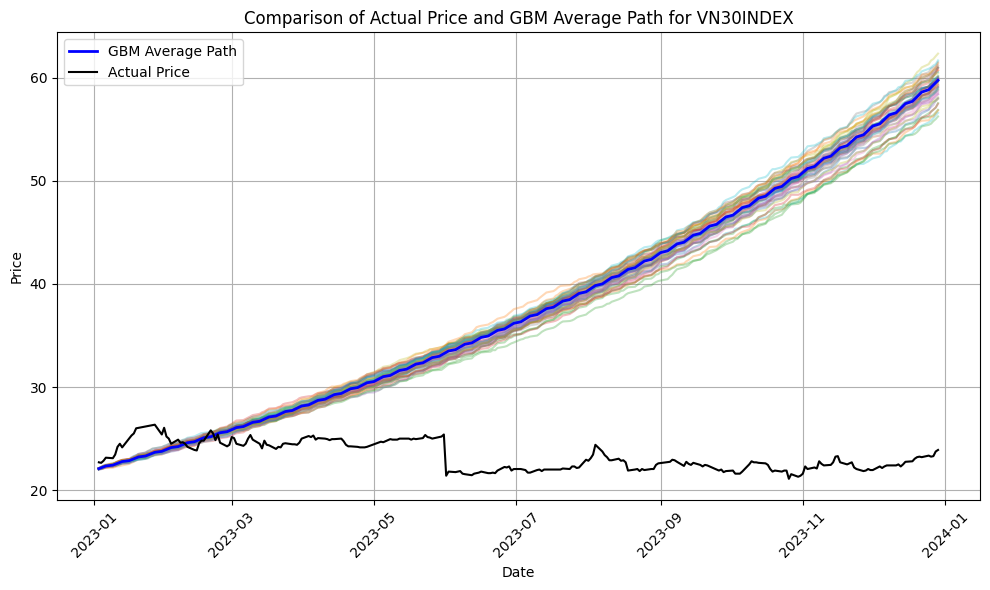

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Read the average path data
average_path_data = pd.read_csv('./data/GBM_paths/ACB.csv')

# Convert 'date' column to datetime format
average_path_data['date'] = pd.to_datetime(average_path_data['date'])

# Filter actual price data for ACB from hose_df_2023
actual_price_data = hose_df_2023[hose_df_2023['ticker'] == 'ACB'][['date', 'close']]

# Plot actual price and average GBM path
plt.figure(figsize=(10, 6))

# Plot randomly selected 50 GBM paths
gbm_paths = random.sample(list(average_path_data.columns[1:]), 50)
for col in gbm_paths:
    plt.plot(average_path_data['date'], average_path_data[col], alpha=0.3)

# Plot average GBM path with a bold line
plt.plot(average_path_data['date'], average_path_data['average'], label='GBM Average Path', color='blue', linewidth=2)

# Plot actual price
plt.plot(actual_price_data['date'], actual_price_data['close'], label='Actual Price', color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Comparison of Actual Price and GBM Average Path for VN30INDEX')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()